# Econ C142 Problem Set 3
# Sahil Chinoy

In [127]:
%matplotlib inline
import math
import scipy
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

## Problem 1

In [128]:
PersonYear = pd.read_table('sat_marriage.out', index_col=0)

In [129]:
PersonYear.head(n=30)

,PID,AGE,Y,CENSORED,SAT,VILLAGE_PAIR
0,1001,14,0,1,0,7
1,1001,15,0,1,0,7
2,1001,16,0,1,0,7
3,1001,17,0,1,0,7
4,1001,18,0,1,0,7
5,1001,19,0,1,0,7
6,1001,20,0,1,0,7
7,1001,21,0,1,0,7
8,1006,14,0,1,0,7
9,1006,15,0,1,0,7


The first woman, who we begin following at age 14, reaches age 21 without being married, at which point she is lost to follow-up (censored). The second woman, who we begin following at age 14, also reaches age 21 without being maried, at which point she is censored. The third woman, who we begin following at age 14, reaches age 20 without being married, at which point she is censored. The fourth woman, who we begin following at age 13, is married at age 18. None of these women live in an SAT village.

## Problem 2

In [130]:
# Create age dummies
PersonYear = pd.concat(
    [
        PersonYear,
        pd.get_dummies(PersonYear['AGE'], prefix = 'AGE')
    ],
    axis=1)

In [131]:
def is_age_23(row):
    """
    Returns 1 if the age of this observation is weakly
    greater than 23. Otherwise returns 0.
    """
    if row['AGE'] >= 23:
        return 1
    else:
        return 0

# Create dummy for age >= 23
PersonYear['AGE_23+'] = PersonYear.apply(is_age_23, axis=1)

## Problem 3

To avoid multicollinearity, we estimate the logit model without a constant term. Exactly one of the age dummies will be 1 for each observation, therefore the set of all age dummies always sums to 1. This means we can always predict the constant term by adding all the age dummies, which is the definition of multicollinearity.

In [132]:
# Independent variables: age dummies from 12 to 22 and 23+
cols = ['AGE_{}'.format(age) for age in range(12, 23)]
cols.append('AGE_23+')
X = PersonYear[cols]
# Fit logit model of marriage indicator on independent variables
mod = sm.Logit(PersonYear['Y'], X)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.237944
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 4748
Model:                          Logit   Df Residuals:                     4736
Method:                           MLE   Df Model:                           11
Date:                Thu, 20 Apr 2017   Pseudo R-squ.:                 0.05505
Time:                        11:23:57   Log-Likelihood:                -1129.8
converged:                       True   LL-Null:                       -1195.6
                                        LLR p-value:                 8.180e-23
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
AGE_12        -5.1874      0.709     -7.316      0.000        -6.577    -3.798
AGE_13        -4.2140      0.356    -11.832      0.000        -4.912    -3.516
AGE_14        -3.4575      0.233    -14.839      0.000        -3.914    -3.001
AGE_15        -2.6391      0.158    -16.719      0.000        -2.948    -2.330
AGE_16        -2.3425      0.142    -16.442      0.000        -2.622    -2.063
AGE_17        -2.2929      0.146    -15.758      0.000        -2.578    -2.008
AGE_18        -2.1422      0.144    -14.892      0.000        -2.424    -1.860
AGE_19        -1.9694      0.145    -13.557      0.000        -2.254    -1.685
AGE_20        -2.3979      0.234    -10.267      0.000        -2.856    -1.940
AGE_21        -1.8539      0.298     -6.215      0.000        -2.439    -1.269
AGE_22        -2.0794      0.474     -4.384      0.000        -3.009    -1.150
AGE_23+       -2.2618      0.470     -4.813      0.000        -3.183    -1.341
==============================================================================
"""

In [135]:
def logit_to_hazard(logit):
    """
    Takes a coefficient from the logit model and
    returns the hazard estimate.
    """
    return math.exp(logit)/(1 + math.exp(logit))

# We don't want to compute the hazard for 23+
hazard = res.params[:-1].apply(logit_to_hazard)

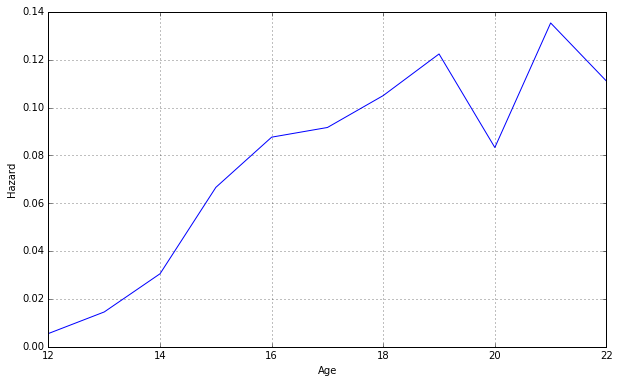

In [136]:
# Plot the baseline hazard
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_xlabel('Age')
ax.set_ylabel('Hazard')
ax.plot(range(12,23), hazard)
plt.grid(True)
plt.show()

## Problem 4

In [138]:
from functools import reduce

def kaplan_meier(hazards):
    """
    Takes a series of hazard estimates
    and returns the Kaplan-Meier survival
    function estimates.
    """
    km = []
    for i in range(len(hazards)):
        estimate = reduce(
            lambda x,y: x*y,
            [(1 - hazard) for hazard in hazards[:i+1]]
        )
        km.append(estimate)
    return km

# Estimate of survival function
survival = kaplan_meier(hazard)

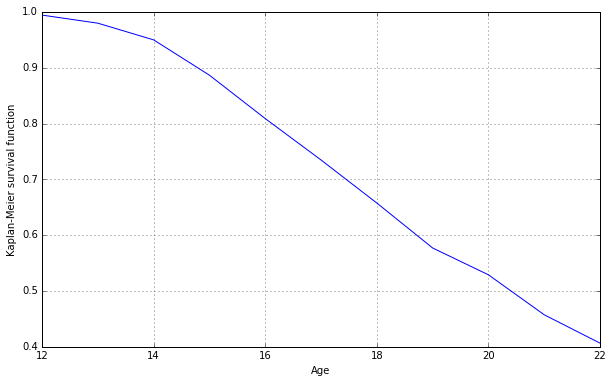

In [139]:
# Plot the Kaplan-Meier survival function estimate
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_xlabel('Age')
ax.set_ylabel('Kaplan-Meier survival function')
ax.plot(range(12,23), survival)
plt.grid(True)
plt.show()

## Problem 5

In [140]:
"""
Create list of (N,D) tuples, one for each age 12 to 22
where N is the number of unmarried women who have not been censored (yet)
and D is the number of women who get married at this age.
"""

_data = []
for age in range(12, 23):
    N  = len(PersonYear[PersonYear['AGE'] == age])
    D = len(PersonYear[(PersonYear['AGE'] == age) & (PersonYear['Y'] == 1)])
    _data.append((N,D))

# Compute the variance estimator of the Kaplan-Meier survival function
var = []
for i in range(len(data)):
    var.append(survival[i]**2 * sum([D/(N*(N-D)) for N,D in data[:i+1]]))

# z-value for a 95% confidence interval
z = scipy.stats.norm.ppf(0.975)
# CI lower and upper bounds
lower = survival - z*np.sqrt(var)
upper = survival + z*np.sqrt(var)

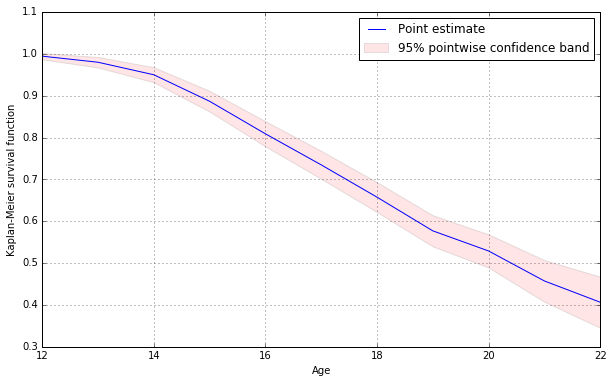

In [142]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_xlabel('Age')
ax.set_ylabel('Kaplan-Meier survival function')
ax.plot(range(12,23), kaplan_meier(hazard), label='Point estimate')
ax.fill_between(
    range(12,23),
    lower,
    upper,
    facecolor='red',
    alpha=0.1,
    label='95% pointwise confidence band'
)
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

## Problem 6

In [143]:
from statsmodels.tools.tools import add_constant

X = PersonYear['AGE']
X = add_constant(X)
mod = sm.Logit(PersonYear['Y'], X)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.243450
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 4748
Model:                          Logit   Df Residuals:                     4746
Method:                           MLE   Df Model:                            1
Date:                Thu, 20 Apr 2017   Pseudo R-squ.:                 0.03318
Time:                        11:29:34   Log-Likelihood:                -1155.9
converged:                       True   LL-Null:                       -1195.6
                                        LLR p-value:                 5.250e-19
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -5.6935      0.361    -15.787      0.000        -6.400    -4.987
AGE            0.1867      0.021      8.992      0.000         0.146     0.227
==============================================================================
"""

In [117]:
restricted_logit = [res.params['const'] + res.params['AGE']*age for age in range(12,23)]
restricted_hazard = [logit_to_hazard(l) for l in restricted_logit]

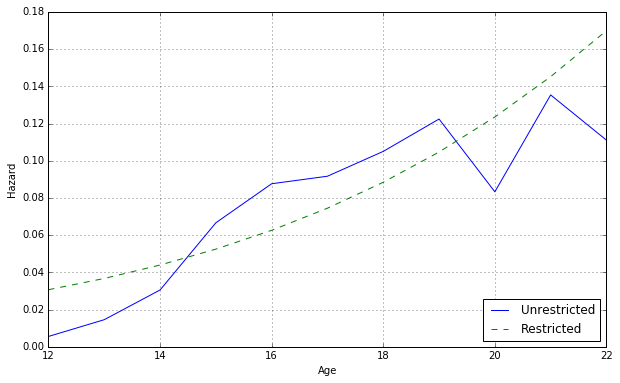

In [147]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.set_xlabel('Age')
ax.set_ylabel('Hazard')
ax.plot(range(12,23), hazard, label='Unrestricted')
ax.plot(range(12,23), restricted_hazard, linestyle='dashed', label='Restricted')
ax.legend(loc='lower right')
plt.grid(True)
plt.show()

When we impose the restriction that the logit of the hazard is linear in age, we get the smooth dashed curve. This approximates the unrestricted model reasonably well for ages around 14 to 19, but we see that the restricted model predicts that the hazard will continue to grow for ages greater than 20, whereas the unrestricted model shows that the hazard might level off around age 20 and eventually decline, which matches our intuition that the likelihood of being married at age 30 should not be greater than the likelihood of being married at age 20, especially in this rural context. The restricted model also seems to predict a higher hazard rate for young girls ages 12 to 14.

## Problem 7

In [146]:
# Add SAT indicator to independent variables
cols.append('SAT')
X = PersonYear[cols]
# Fit logit model of marriage indicator
mod = sm.Logit(PersonYear['Y'], X)
res = mod.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 0.237943
         Iterations 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      Y   No. Observations:                 4748
Model:                          Logit   Df Residuals:                     4735
Method:                           MLE   Df Model:                           12
Date:                Thu, 20 Apr 2017   Pseudo R-squ.:                 0.05505
Time:                        11:30:58   Log-Likelihood:                -1129.8
converged:                       True   LL-Null:                       -1195.6
                                        LLR p-value:                 2.906e-22
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
AGE_12        -5.1825      0.711     -7.289      0.000        -6.576    -3.789
AGE_13        -4.2091      0.360    -11.692      0.000        -4.915    -3.504
AGE_14        -3.4525      0.239    -14.438      0.000        -3.921    -2.984
AGE_15        -2.6341      0.167    -15.810      0.000        -2.961    -2.308
AGE_16        -2.3376      0.152    -15.357      0.000        -2.636    -2.039
AGE_17        -2.2880      0.155    -14.756      0.000        -2.592    -1.984
AGE_18        -2.1373      0.153    -13.934      0.000        -2.438    -1.837
AGE_19        -1.9645      0.155    -12.685      0.000        -2.268    -1.661
AGE_20        -2.3929      0.240     -9.979      0.000        -2.863    -1.923
AGE_21        -1.8487      0.304     -6.089      0.000        -2.444    -1.254
AGE_22        -2.0740      0.478     -4.339      0.000        -3.011    -1.137
AGE_23+       -2.2575      0.472     -4.781      0.000        -3.183    -1.332
SAT           -0.0107      0.116     -0.092      0.927        -0.238     0.217
==============================================================================
"""

Prior research on the SAT program has suggested that it increases the empowerment of female students, so we might expect to find that being in an SAT village decreases the hazard rate of marriage at an early age. Howver, the coefficient on SAT is small and statistically insignificant ($|z| < 0.1$). This means we cannot reject the null hypothesis that exposure to the SAT tutorial model has no effect on age of first marriage. This is not entirely unexpected, given that the intervention was not targeted at reducing early marriage specifically, and the effects of better middle-school education on marriage age are not *a priori* clear.